<a href="https://colab.research.google.com/github/AMEERKOTTA/hands_on_machine_learning_with_sklearn_keras_and_tensorflow/blob/main/Intro%20to%20Tensorflow%20for%20Deep%20Learning/07-Time%20Series%20Forecasting/09_forecasting_using_gru_layers_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FORECASTING USING GRU LAYERS MODEL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

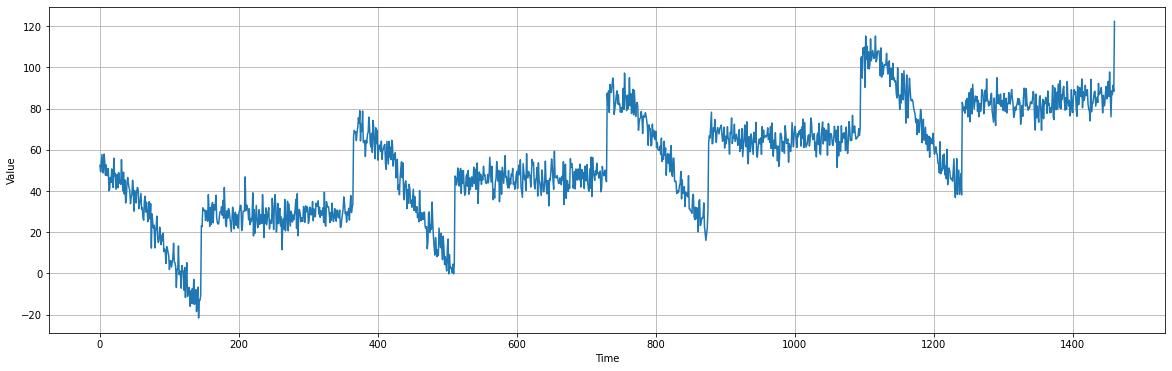

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(20, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
## class to reset the cell state after every epochs
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [6]:
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.GRU(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.GRU(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/100
33/33 [==============================] - 12s 43ms/step - loss: 72.2716 - mae: 72.7710 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 1s 35ms/step - loss: 46.2153 - mae: 46.7137 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 1s 32ms/step - loss: 29.5401 - mae: 30.0360 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 1s 21ms/step - loss: 26.7741 - mae: 27.2692 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 1s 23ms/step - loss: 25.7445 - mae: 26.2396 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 1s 22ms/step - loss: 24.8647 - mae: 25.3595 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 1s 21ms/step - loss: 23.8883 - mae: 24.3814 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 1s 21ms/step - loss: 22.8661 - mae: 23.3596 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 1s 21ms/step - loss: 21.7803 - mae

(1e-08, 0.0001, 0.0, 30.0)

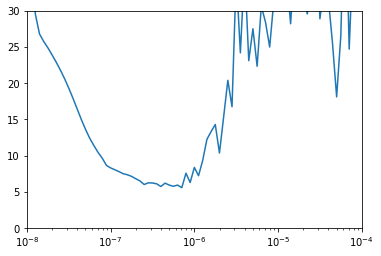

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
## training with training period and validation on validation period.
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.GRU(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.GRU(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 7s 69ms/step - loss: 42.8568 - mae: 43.3551 - val_loss: 15.0998 - val_mae: 15.5935
Epoch 2/500
33/33 [==============================] - 1s 27ms/step - loss: 18.3895 - mae: 18.8827 - val_loss: 16.3909 - val_mae: 16.8863
Epoch 3/500
33/33 [==============================] - 1s 27ms/step - loss: 18.7864 - mae: 19.2816 - val_loss: 25.1256 - val_mae: 25.6223
Epoch 4/500
33/33 [==============================] - 1s 27ms/step - loss: 11.9437 - mae: 12.4327 - val_loss: 20.4725 - val_mae: 20.9695
Epoch 5/500
33/33 [==============================] - 1s 27ms/step - loss: 11.5791 - mae: 12.0706 - val_loss: 19.4404 - val_mae: 19.9368
Epoch 6/500
33/33 [==============================] - 1s 29ms/step - loss: 15.0709 - mae: 15.5656 - val_loss: 12.6941 - val_mae: 13.1849
Epoch 7/500
33/33 [==============================] - 1s 28ms/step - loss: 17.3183 - mae: 17.8115 - val_loss: 10.4368 - val_mae: 10.9296
Epoch 8/500
33/33 [=============================

In [9]:
model = keras.models.load_model("my_checkpoint.h5")

In [11]:
gru_forecast = model.predict(series[np.newaxis, :, np.newaxis])
gru_forecast = gru_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 0s 433ms/step


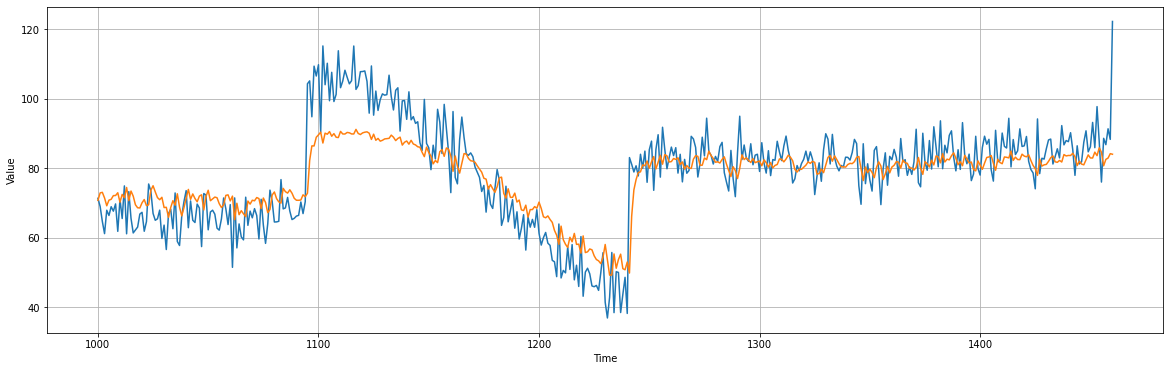

In [12]:
plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, gru_forecast)

In [14]:
keras.metrics.mean_absolute_error(x_valid, gru_forecast).numpy()

6.3431845

`GRU FORECAST MAE = 6.3`

***